In [1]:
import sys, os
from fractions import Fraction
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ms3 import transform, name2fifths, fifths2pc
sys.path.append(os.path.abspath('../python_scripts/'))
from data_types import ChordType, PitchType
from utils import get_chord_pitches
from constants import TRIAD_REDUCTION
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

def vc(S):
    """Value counts & normalized column"""
    vc = S.value_counts(dropna=False)
    N = vc.sum()
    print(f"N = {vc.sum()}")
    return pd.concat([vc, vc / N], axis=1, keys=['counts', 'fraction'])

def normalize_groups(groupby, level=[0,1]):
    size = groupby.size()
    print(f"N = {size.sum()}")
    norm = size.groupby(level=level).apply(lambda S: S / S.sum())
    return pd.concat([size, norm], axis=1, keys=['counts', 'fraction_within_group'])

In [2]:
data = '../Data/sonatas_annotations/progressions'
csv_files = [f for f in os.listdir(data) if f.endswith(".csv")]
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time  matched_duration annotation1_chord annotation2_chord dcml_label  \
01-1 0  0.00              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     1  0.25              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     2  0.50              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     3  0.75              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     4  1.00              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   

        sps  vl tbt  binary  
01-1 0  0.0   0   0   False  
     1  0.0   0   0   False  
     2  0.0   0   0   False  
     3  0.0   0   0   False  
     4  0.0   0   0   False

### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [3]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.561696
True     0.438304
Name: binary, dtype: float64


### Data Expansion

In [4]:
df = D[D.sps > 0] # select only diverging
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
changes_re = r"\((?:(?:\+|-|\^|v)?(?:b*|\#*)\d)+\)"
def is_triad(type_str):
    val = ChordType[type_str]
    return val.value < 4
df = pd.concat([df, df.dcml_label.str.contains(changes_re).rename('dcml_has_changes')], axis=1) 
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'triad': f"triad{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['triad'] = transform(expanded[2], is_triad)
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)

In [5]:
def tbt_relaxed(set_a, set_b, as_distance=False):
    """Tone-by-tone but normalizing by 3 if a triad is involved.
    Returns 1 if a triad is contained in a tetrad.
    """
    n = min(len(set_a), len(set_b))
    overlap = len(set_a.intersection(set_b)) / n
    if as_distance:
        overlap = 1 - overlap
    return Fraction(overlap).limit_denominator(n)
    
def tbt_relaxed_cacheable(pc1, pc2, type1, type2, as_distance=False):
    a = set(get_chord_pitches(pc1, ChordType[type1], PitchType.MIDI) % 12)
    b = set(get_chord_pitches(pc2, ChordType[type2], PitchType.MIDI) % 12)
    return tbt_relaxed(a, b, as_distance=as_distance)

overlap = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2']).rename('overlap')
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv'),
                overlap,
               ], axis=1)
df.pc_iv = df.pc_iv.where(df.pc_iv <= 6, 12 - df.pc_iv)
df.head()

time  matched_duration  annotation1_chord annotation2_chord  \
01-1 30   5.25             0.250  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2   
     43   7.25             0.250       C_MAJOR_inv0   C_MAJ_MIN7_inv0   
     56  10.25             0.375   Db_MAJ_MAJ7_inv3  Db_MAJ_MAJ7_inv1   
     80  14.25             0.250      Bb_MINOR_inv1     Bb_MINOR_inv1   
     87  16.00             0.250      Ab_MAJOR_inv1     Eb_MAJOR_inv0   

        dcml_label       sps  vl  tbt  binary  dcml_has_changes root1  \
01-1 30     #viio6  0.049170   2  3/8    True             False     E   
     43      V(4)}  0.273761   3  1/4    True              True     C   
     56   III.IVM2  0.075546  15  1/4    True             False    Db   
     80     ii6(2)  0.262297   2  1/7   False              True    Bb   
     87        I6{  0.447499  12  6/7    True             False    Ab   

              type1 inv1  triad1  tpc1  pc1 root2     type2 inv2  triad2  \
01-1 30  DIMINISHED    1    True     4    4     C  MAJ_MIN7    2   False   
     43       MAJOR    0    True     0    0     C  MAJ_MIN7    0   False   
     56    MAJ_MAJ7    3   False    -5    1    Db  MAJ_MAJ7    1   False   
     80       MINOR    1    True    -2   10    Bb     MINOR    1    True   
     87       MAJOR    1    True    -4    8    Eb     MAJOR    0    True   

         tpc2  pc2  tpc_iv  pc_iv overlap  
01-1 30     0    0       4      4       1  
     43     0    0       0      0       1  
     56    -5    1       0      0       1  
     80    -2   10       0      0       1  
     87    -3    3       1      5     1/3

### SPS by shared tones ('relaxed tbt')
Maximum overlap is the minimum number of tones between the two chords, so if a triad's notes are all included in a tetrad, the overlap is 1.

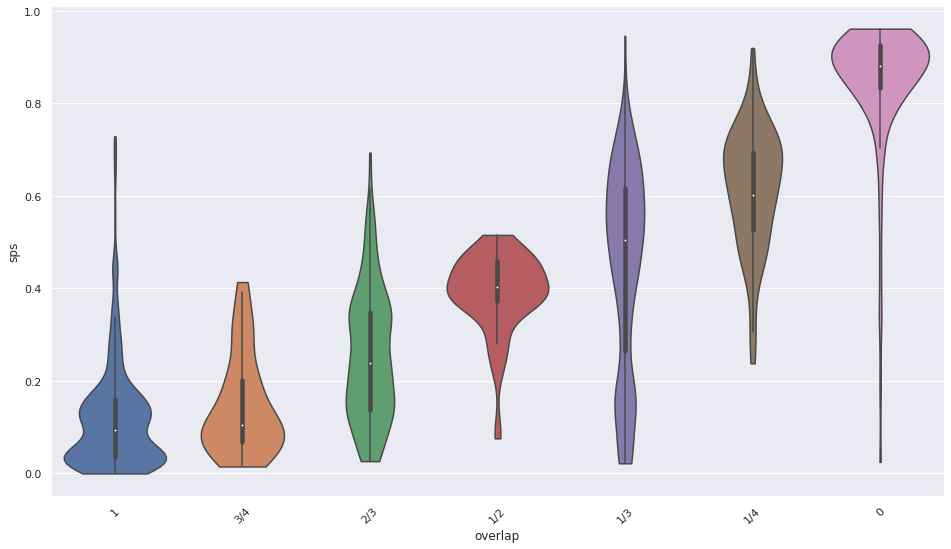

In [6]:
sns.set(rc={"figure.figsize":(16, 9)})
sns.violinplot(data=df, x='overlap', y='sps', order=sorted(df.overlap.unique(), reverse=True), cut=0)
plt.xticks(rotation=45)
plt.show()

### Categorize divergences

**Create boolean masks**

In [7]:
def reduce_tetrad(type_str):
    val = ChordType[type_str]
    return TRIAD_REDUCTION[val]

same_type_reduced = transform(df.type1, reduce_tetrad) == transform(df.type2, reduce_tetrad)
same_root = df.pc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2
diverging_inv = same_root & same_type & ~same_inversion
diverging_type = same_root & ~same_type & same_inversion
diverging_root = ~same_root & same_type & same_inversion

In [8]:
ctgs = pd.Series(index=df.index, dtype='string', name='divergence')
triad_tetrad = same_root & same_type_reduced & (df.triad1 != df.triad2) # the latter part was missing in the first version of the plots. It ensures that only one is a triad
triad_tetrad_root = overlap == 1
both_triads = df.triad1 & df.triad2
selectors = (
    ('inversion', diverging_inv),
    ('triad-tetrad', triad_tetrad & same_inversion),
    ('triad-tetrad & inversion', triad_tetrad & ~same_inversion),
    ('type', diverging_type),
    ('type & inversion', same_root),
    ('triad-tetrad & root', triad_tetrad_root),
    ('no_overlap', overlap == 0),
    ('tetrads_sharing_3', overlap == 3/4),
    ('tetrads_sharing_2', overlap == 1/2),
    ('tetrads_sharing_1', overlap== 1/4),
    ('triads_sharing_2',  (overlap == Fraction(2,3)) & both_triads),
    ('triad_tetrad_sharing_2', (overlap == Fraction(2,3)) & ~both_triads),
    ('triads_sharing_1', (overlap == Fraction(1,3)) & both_triads),
    ('triad_tetrad_sharing_1', (overlap == Fraction(1,3)) & ~both_triads),
    )
for c, sel in selectors:
    ctgs = ctgs.where(ctgs.notna(), sel.map({True: c, False: pd.NA}))
## Now, fill in the uncategorized with the fraction of diverging notes
tbt_rel = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2'], as_distance=True)
ctgs = ctgs.where(ctgs.notna(), tbt_rel.astype(str))
vc(ctgs)

N = 3480


,counts,fraction
inversion,688,0.197701
triads_sharing_1,584,0.167816
type & inversion,383,0.110057
triad-tetrad,356,0.102299
triad_tetrad_sharing_1,327,0.093966
no_overlap,294,0.084483
triad_tetrad_sharing_2,159,0.04569
triads_sharing_2,158,0.045402
triad-tetrad & root,147,0.042241
triad-tetrad & inversion,98,0.028161


#### SPS distributions for the different categories

In [9]:
order_by_median = df.groupby(ctgs).sps.median().sort_values().index.to_list()
labels = [f"{l} ({ctgs.value_counts(normalize=True)[l]:.1%})" for l in order_by_median]

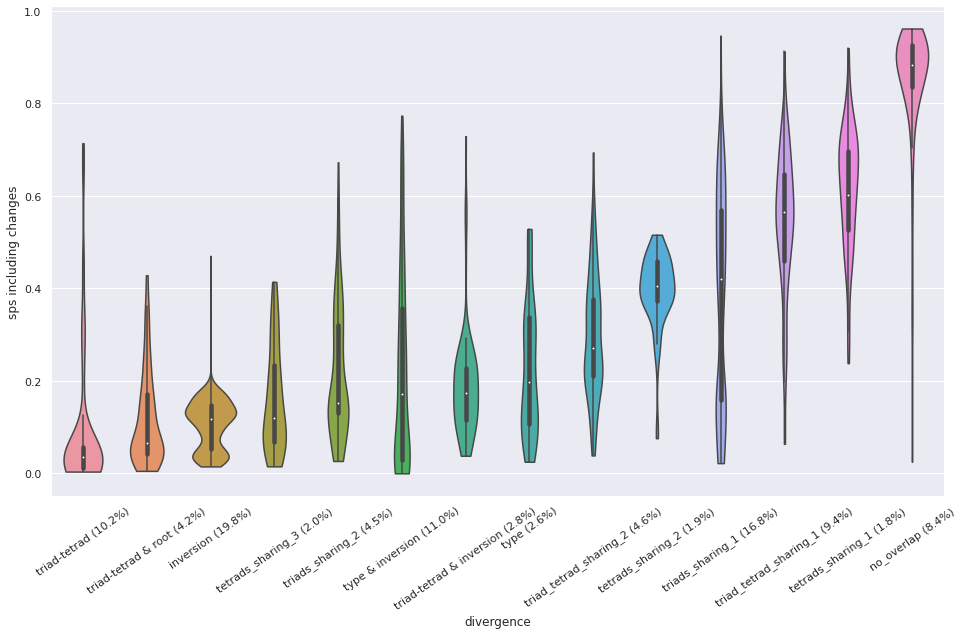

In [10]:
sns.set(rc={"figure.figsize":(16, 9)})
ax = sns.violinplot(data=df, x=ctgs, y='sps', order=order_by_median, cut=0)
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
plt.ylabel('sps including changes')
plt.savefig('../figures/categories_sps_with_changes.png', bbox_inches='tight')
plt.show()

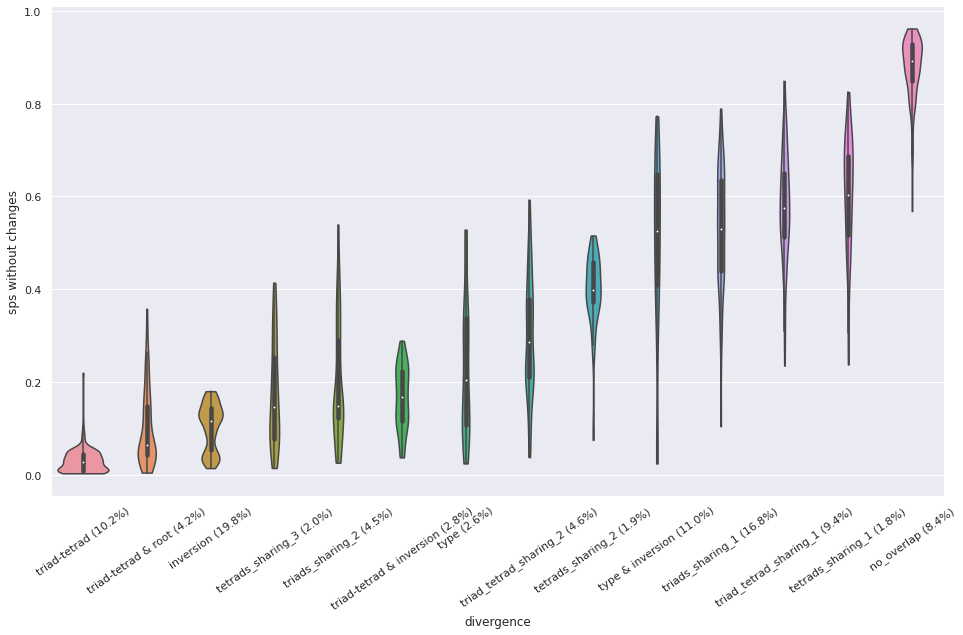

In [11]:
without_changes = ~df.dcml_has_changes
df_without = df[without_changes]
ctgs_without = ctgs[without_changes]
order_by_median_without = df_without.groupby(ctgs_without).sps.median().sort_values().index.to_list()
labels_without = [f"{l} ({ctgs.value_counts(normalize=True)[l]:.1%})" for l in order_by_median_without]
sns.set(rc={"figure.figsize":(16, 9)})
ax = sns.violinplot(data=df_without, x=ctgs_without, y='sps', order=order_by_median_without, cut=0)
ax.set_xticklabels(labels_without)
plt.xticks(rotation=35)
plt.ylabel('sps without changes')
plt.savefig('../figures/categories_sps_without_changes.png', bbox_inches='tight')
plt.show()

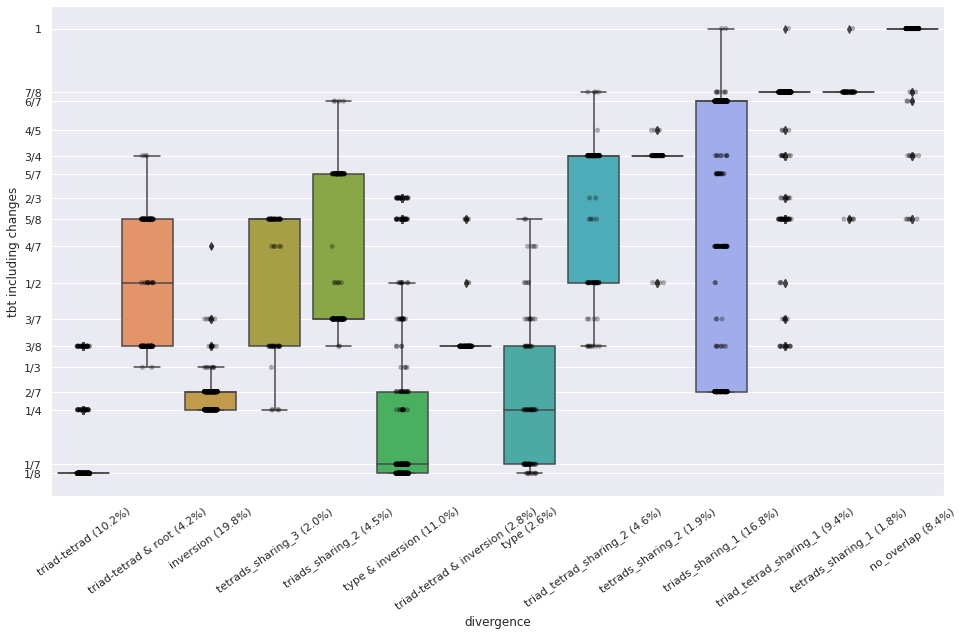

In [12]:
ax = sns.boxplot(data=df, x=ctgs, y='tbt', order=order_by_median)
ax = sns.stripplot(data=df, x=ctgs, y='tbt', order=order_by_median, marker="o", alpha=0.3, color="black")
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
yticks = sorted(df.tbt.unique())
plt.yticks(df.tbt.astype(float).unique(), df.tbt.unique())
plt.ylabel('tbt including changes')
plt.savefig('../figures/categories_tbt_with_changes.png', bbox_inches='tight')
plt.show()

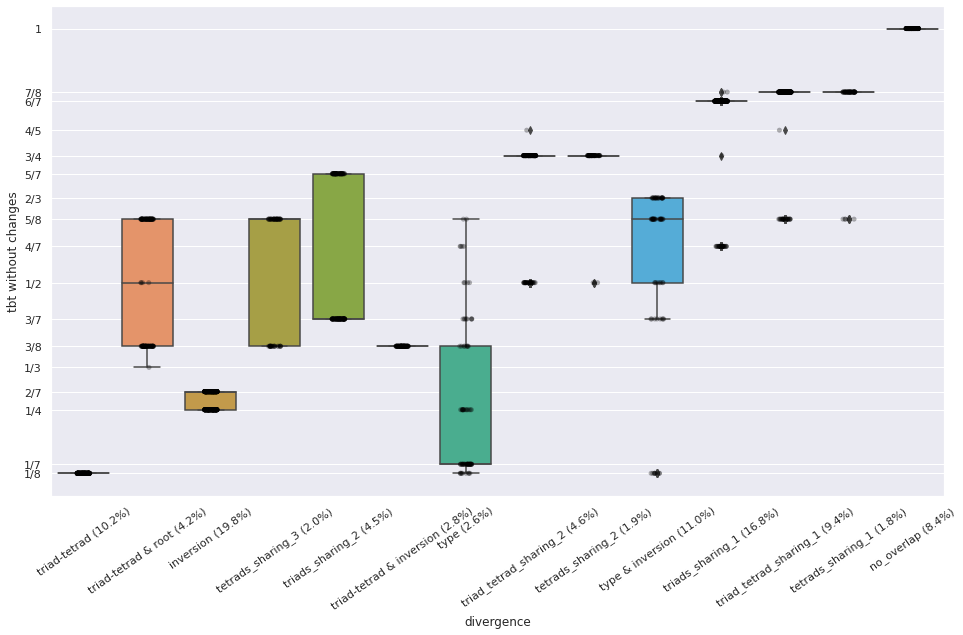

In [13]:
ax = sns.boxplot(data=df_without, x=ctgs_without, y='tbt', order=order_by_median_without)
ax = sns.stripplot(data=df_without, x=ctgs_without, y='tbt', order=order_by_median_without, marker="o", alpha=0.3, color="black")
ax.set_xticklabels(labels_without)
plt.xticks(rotation=35)
yticks = sorted(df_without.tbt.unique())
plt.yticks(df_without.tbt.astype(float).unique(), df_without.tbt.unique())
plt.ylabel('tbt without changes')
plt.savefig('../figures/categories_tbt_without_changes.png', bbox_inches='tight')
plt.show()

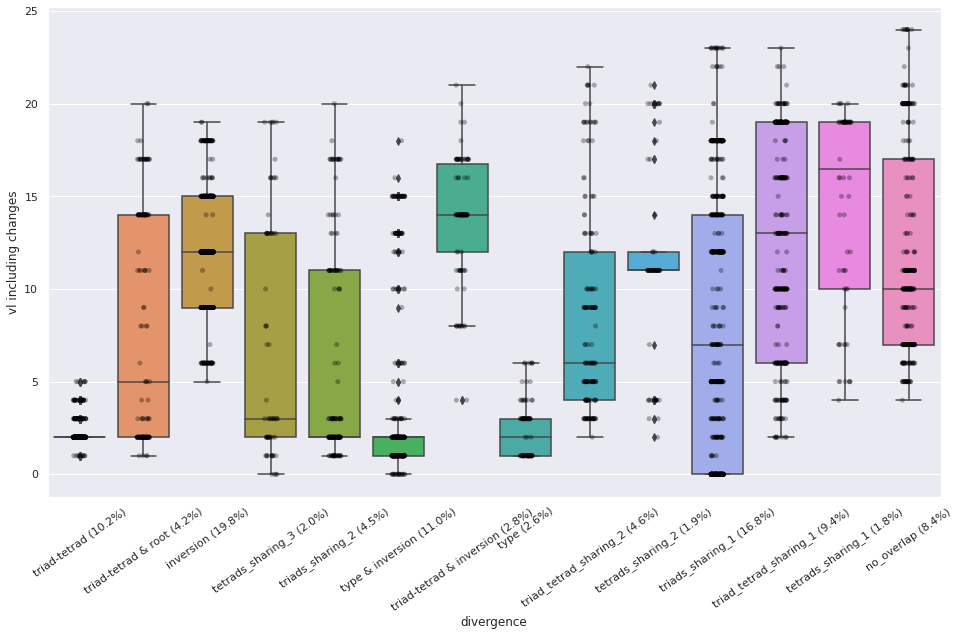

In [14]:
ax = sns.stripplot(data=df, x=ctgs, y='vl', order=order_by_median, marker="o", alpha=0.3, color="black")
ax = sns.boxplot(data=df, x=ctgs, y='vl', order=order_by_median)
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
plt.ylabel('vl including changes')
plt.savefig('../figures/categories_vl_with_changes.png', bbox_inches='tight')
plt.show()

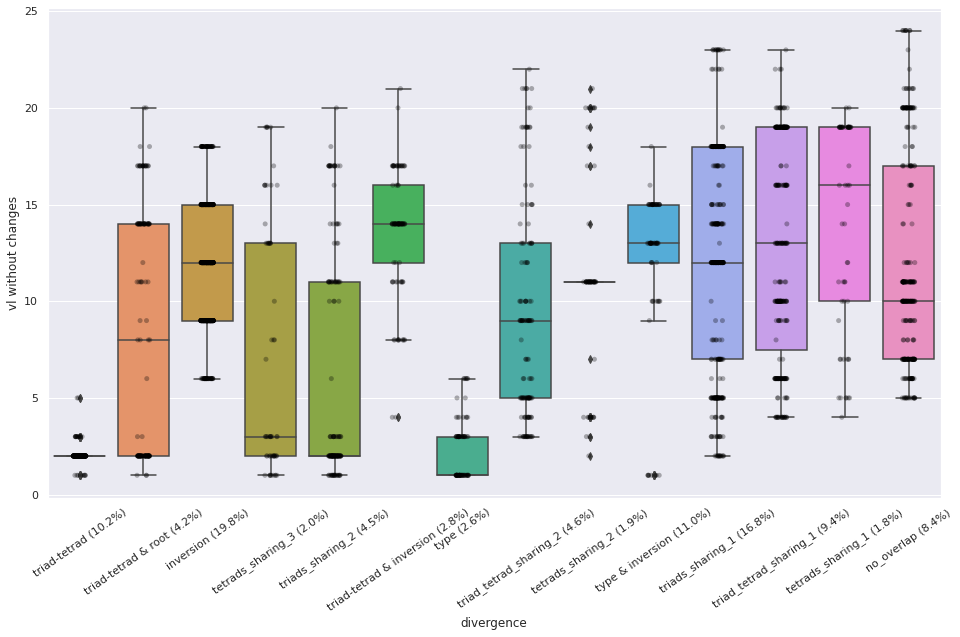

In [15]:
ax = sns.stripplot(data=df_without, x=ctgs_without, y='vl', order=order_by_median_without, marker="o", alpha=0.3, color="black")
ax = sns.boxplot(data=df_without, x=ctgs_without, y='vl', order=order_by_median_without)
ax.set_xticklabels(labels_without)
plt.xticks(rotation=35)
plt.ylabel('vl without changes')
plt.savefig('../figures/categories_vl_without_changes.png', bbox_inches='tight')
plt.show()

# Combining metrics for more fine-grained error categories
## Triad-tetrad SPS divided by VL values

In [16]:
tri_tet = df[ctgs == 'triad-tetrad'].copy()
tri_tet.groupby('vl').sps.describe()

,count,mean,std,min,25%,50%,75%,max
vl,,,,,,,,
1,10.0,0.024191,0.005525,0.018653,0.020385,0.021478,0.027749,0.032689
2,269.0,0.030980,0.027361,0.003718,0.009006,0.027558,0.049487,0.284466
3,42.0,0.190753,0.133083,0.010659,0.045257,0.229566,0.303313,0.437962
4,29.0,0.439841,0.185372,0.061140,0.338501,0.445551,0.644643,0.710692
5,6.0,0.549144,0.254989,0.219955,0.343401,0.713739,0.713739,0.713739


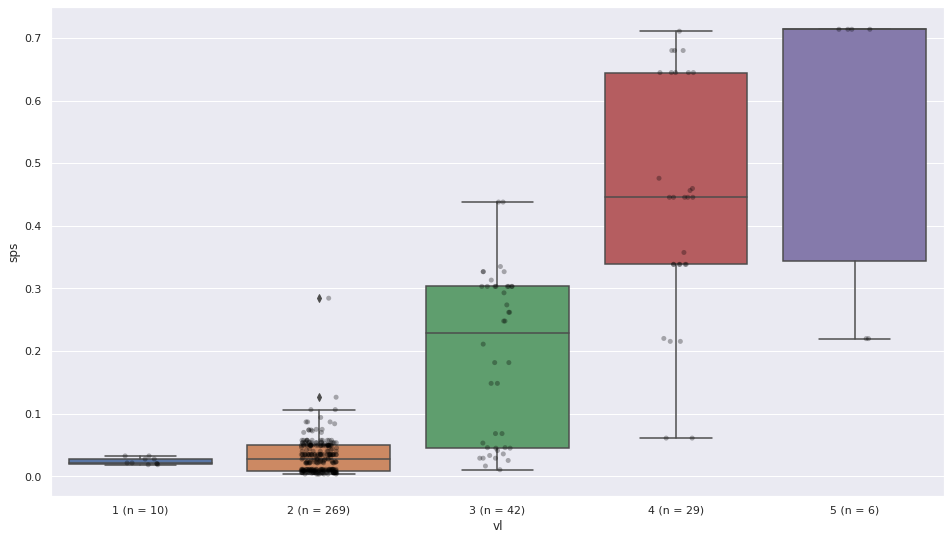

In [17]:
ax = sns.boxplot(data=tri_tet, x='vl', y='sps')
ax = sns.stripplot(data=tri_tet, x='vl', y='sps', marker="o", alpha=0.3, color="black")
ax.set_xticklabels([f"{i} (n = {n})" for i, n in tri_tet.groupby('vl').size().iteritems()])
plt.show()

In [18]:
comparisons = ('tpc', 'pc', 'type', 'inv', 'triad') 
tri_tet_groups = {compare: tri_tet[[f"{compare}1", f"{compare}2"]].apply(lambda row: tuple(sorted(row)), axis=1) for compare in comparisons}

### Chord type combinations for the different VL values
Chord combinations in this category share the same root, inversion, and reduced chord type.

In [19]:
tri_tet.groupby([tri_tet.vl, tri_tet_groups['type']]).size()

vl                         
1   (MAJOR, MAJ_MAJ7)            8
    (MAJOR, MAJ_MIN7)            2
2   (DIMINISHED, HALF_DIM7)      9
    (MAJOR, MAJ_MIN7)          246
    (MINOR, MIN_MIN7)           14
3   (DIM7, DIMINISHED)          13
    (MAJOR, MAJ_MIN7)           29
4   (MAJOR, MAJ_MIN7)           29
5   (DIM7, DIMINISHED)           2
    (MAJOR, MAJ_MIN7)            4
dtype: int64

**The three different VL values seem to be dependent on the size of the 7th**

In [20]:
tri_tet.groupby([tri_tet.vl, tri_tet_groups['type'], tri_tet_groups['inv']]).sps.describe()

count      mean       std       min  \
vl                                                                       
1  (MAJOR, MAJ_MAJ7)       (0, 0)    2.0  0.020385  0.000000  0.020385   
                           (1, 1)    6.0  0.024273  0.006639  0.018653   
   (MAJOR, MAJ_MIN7)       (0, 0)    2.0  0.027749  0.000000  0.027749   
2  (DIMINISHED, HALF_DIM7) (0, 0)    6.0  0.017774  0.019522  0.005145   
                           (1, 1)    3.0  0.032495  0.005286  0.026391   
   (MAJOR, MAJ_MIN7)       (0, 0)  180.0  0.022708  0.025561  0.003718   
                           (1, 1)   56.0  0.048180  0.012054  0.026506   
                           (2, 2)   10.0  0.081457  0.028544  0.032067   
   (MINOR, MIN_MIN7)       (0, 0)    9.0  0.026630  0.020700  0.005288   
                           (1, 1)    3.0  0.050205  0.037991  0.028271   
                           (2, 2)    2.0  0.069524  0.020499  0.055029   
3  (DIM7, DIMINISHED)      (0, 0)    7.0  0.030721  0.012248  0.010659   
                           (1, 1)    4.0  0.039831  0.006099  0.033386   
                           (2, 2)    2.0  0.047241  0.008470  0.041251   
   (MAJOR, MAJ_MIN7)       (0, 0)   21.0  0.272834  0.096220  0.016561   
                           (1, 1)    8.0  0.226655  0.104563  0.068350   
4  (MAJOR, MAJ_MIN7)       (0, 0)   26.0  0.472140  0.160177  0.215547   
                           (1, 1)    3.0  0.159916  0.171084  0.061140   
5  (DIM7, DIMINISHED)      (1, 1)    2.0  0.219955  0.000000  0.219955   
   (MAJOR, MAJ_MIN7)       (0, 0)    4.0  0.713739  0.000000  0.713739   

                                        25%       50%       75%       max  
vl                                                                         
1  (MAJOR, MAJ_MAJ7)       (0, 0)  0.020385  0.020385  0.020385  0.020385  
                           (1, 1)  0.019359  0.021478  0.029884  0.032689  
   (MAJOR, MAJ_MIN7)       (0, 0)  0.027749  0.027749  0.027749  0.027749  
2  (DIMINISHED, HALF_DIM7) (0, 0)  0.005145  0.007198  0.024218  0.052754  
                           (1, 1)  0.030969  0.035547  0.035547  0.035547  
   (MAJOR, MAJ_MIN7)       (0, 0)  0.009006  0.011275  0.034780  0.284466  
                           (1, 1)  0.040051  0.050373  0.054737  0.074106  
                           (2, 2)  0.059140  0.086984  0.101712  0.126403  
   (MINOR, MIN_MIN7)       (0, 0)  0.008361  0.020821  0.048700  0.048700  
                           (1, 1)  0.028271  0.028271  0.061172  0.094073  
                           (2, 2)  0.062277  0.069524  0.076772  0.084019  
3  (DIM7, DIMINISHED)      (0, 0)  0.027242  0.029046  0.037476  0.045907  
                           (1, 1)  0.035240  0.040449  0.045040  0.045040  
                           (2, 2)  0.044246  0.047241  0.050235  0.053230  
   (MAJOR, MAJ_MIN7)       (0, 0)  0.247994  0.303313  0.303313  0.437962  
                           (1, 1)  0.175441  0.261955  0.298144  0.335048  
4  (MAJOR, MAJ_MIN7)       (0, 0)  0.338501  0.445551  0.644643  0.710692  
                           (1, 1)  0.061140  0.061140  0.209304  0.357467  
5  (DIM7, DIMINISHED)      (1, 1)  0.219955  0.219955  0.219955  0.219955  
   (MAJOR, MAJ_MIN7)       (0, 0)  0.713739  0.713739  0.713739  0.713739

In [21]:
tri_tet[(tri_tet.vl == 3) & (tri_tet_groups['tpc'] == (-1, -1))]

time  matched_duration  annotation1_chord annotation2_chord  \
06-1 805    46.625          0.041667       F_MAJOR_inv1   F_MAJ_MIN7_inv1   
09-1 1090  130.750          0.125000  F_DIMINISHED_inv1       F_DIM7_inv1   
24-1 598    49.500          0.062500  F_DIMINISHED_inv0       F_DIM7_inv0   
     626    51.250          0.062500  F_DIMINISHED_inv0       F_DIM7_inv0   
26-1 362    50.000          0.125000       F_MAJOR_inv0   F_MAJ_MIN7_inv0   
     378    52.000          0.125000       F_MAJOR_inv0   F_MAJ_MIN7_inv0   

          dcml_label       sps  vl  tbt  binary  dcml_has_changes root1  \
06-1 805    V6(6)/IV  0.313373   3  1/4    True              True     F   
09-1 1090  #viio6/ii  0.035858   3  1/8    True             False     F   
24-1 598        viio  0.045907   3  1/8    True             False     F   
     626        viio  0.045907   3  1/8    True             False     F   
26-1 362        V(4)  0.148498   3  1/4    True              True     F   
     378        V(4)  0.148498   3  1/4    True              True     F   

                type1 inv1  triad1  tpc1  pc1 root2     type2 inv2  triad2  \
06-1 805        MAJOR    1    True    -1    5     F  MAJ_MIN7    1   False   
09-1 1090  DIMINISHED    1    True    -1    5     F      DIM7    1   False   
24-1 598   DIMINISHED    0    True    -1    5     F      DIM7    0   False   
     626   DIMINISHED    0    True    -1    5     F      DIM7    0   False   
26-1 362        MAJOR    0    True    -1    5     F  MAJ_MIN7    0   False   
     378        MAJOR    0    True    -1    5     F  MAJ_MIN7    0   False   

           tpc2  pc2  tpc_iv  pc_iv overlap  
06-1 805     -1    5       0      0       1  
09-1 1090    -1    5       0      0       1  
24-1 598     -1    5       0      0       1  
     626     -1    5       0      0       1  
26-1 362     -1    5       0      0       1  
     378     -1    5       0      0       1

# Older code
#### Checking outliers

In [22]:
df[ctgs == 'triads_sharing_1'].groupby('vl').sps.min()

vl
0     0.021957
1     0.023060
2     0.032372
3     0.065433
4     0.270048
5     0.283182
6     0.241781
7     0.216437
8     0.400738
9     0.130603
10    0.347198
11    0.350820
12    0.325617
13    0.272261
14    0.406678
15    0.116644
16    0.320111
17    0.403210
18    0.245541
19    0.568610
20    0.716387
22    0.396430
23    0.636311
Name: sps, dtype: float64

In [23]:
df[(ctgs == 'triads_sharing_1') & (df.vl <= 3)]

time  matched_duration annotation1_chord  annotation2_chord  \
01-1 218    34.25000          0.125000     Eb_MAJOR_inv0      Ab_MAJOR_inv2   
     250    38.25000          0.125000     Eb_MAJOR_inv0      Ab_MAJOR_inv2   
     271    41.25000          0.250000     Eb_MAJOR_inv0      Ab_MAJOR_inv2   
     281    43.25000          0.250000     Eb_MAJOR_inv0      Ab_MAJOR_inv2   
     291    45.25000          0.250000     Eb_MAJOR_inv0      Ab_MAJOR_inv2   
03-1 66     11.00000          0.250000      G_MAJOR_inv0       C_MAJOR_inv2   
     2151  231.00000          0.500000      G_MAJOR_inv0       C_MAJOR_inv2   
     2169  233.00000          0.062500      G_MAJOR_inv0       C_MAJOR_inv2   
05-1 60     14.25000          1.000000      G_MAJOR_inv0       C_MINOR_inv2   
     101    23.25000          0.750000     Eb_MAJOR_inv0      Ab_MAJOR_inv2   
     287    54.75000          0.125000     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     335    60.75000          0.125000     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     339    61.25000          0.125000      G_MAJOR_inv1      Eb_MAJOR_inv2   
     347    62.25000          0.125000     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     351    62.75000          0.125000      G_MAJOR_inv1      Eb_MAJOR_inv2   
     359    63.75000          0.250000     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     370    65.50000          0.187500     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     380    67.00000          0.125000     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     737   139.50000          1.000000      G_MAJOR_inv0       C_MINOR_inv2   
     745   142.50000          0.750000     Db_MAJOR_inv0      Gb_MAJOR_inv2   
     809   159.00000          0.125000     Ab_MAJOR_inv1       F_MAJOR_inv2   
     919   172.50000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     1041  187.50000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     1089  193.50000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     1101  195.00000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     1113  196.50000          0.250000      G_MAJOR_inv0       C_MINOR_inv2   
     1123  198.00000          0.250000      G_MAJOR_inv0       C_MINOR_inv2   
     1133  199.50000          0.250000      G_MAJOR_inv0       C_MINOR_inv2   
06-1 409    28.62500          0.041667      G_MAJOR_inv0       C_MAJOR_inv2   
     469    30.62500          0.041667      G_MAJOR_inv0       C_MAJOR_inv2   
     543    35.37500          0.041667      A_MAJOR_inv2       E_MAJOR_inv0   
     1013   56.12500          0.041667      A_MAJOR_inv0       D_MINOR_inv2   
     1087   63.62500          0.125000      A_MAJOR_inv0       D_MAJOR_inv2   
07-1 114    21.25000          0.750000      D_MAJOR_inv1      Gb_MAJOR_inv0   
     463    78.25000          0.250000      B_MINOR_inv1       D_MINOR_inv0   
     467    79.25000          0.250000      B_MINOR_inv1       D_MINOR_inv0   
     475    81.25000          0.250000      B_MINOR_inv1       D_MINOR_inv0   
     988   168.25000          0.125000      A_MAJOR_inv0       D_MINOR_inv2   
     1020  172.25000          0.125000      A_MAJOR_inv0       D_MINOR_inv2   
     1171  197.25000          0.125000      B_MAJOR_inv0       E_MINOR_inv2   
08-1 163     9.50000          0.062500      G_MAJOR_inv0       C_MINOR_inv2   
     244    16.00000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     308    24.00000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     328    27.00000          0.250000      G_MAJOR_inv0       C_MINOR_inv2   
     352    31.00000          0.250000      G_MAJOR_inv0       C_MINOR_inv2   
     680    86.00000          0.062500     Bb_MAJOR_inv0      Eb_MAJOR_inv2   
     1047  134.75000          0.125000      B_MAJOR_inv0       E_MINOR_inv2   
     1051  135.25000          0.125000      B_MAJOR_inv0       E_MINOR_inv2   
     1529  200.00000          0.125000      G_MAJOR_inv0       C_MINOR_inv2   
     1601  209.00000          0.125000     Ab_MAJOR_inv0      Db_M

In [25]:
def get_value_pair(row, col):
    """Return value pairs such that the first one belongs to the lower of both roots."""
    col1, col2 = f"{col}1", f"{col}2"
    if (row.pc1 + row.pc_iv) % 12 != row.pc2:
        return row[col2], row[col1]
    return row[col1], row[col2]

### Inspect particular divergences
#### Two seventh chords with different roots and 3 common tones
For example, the first row, `1  (MAJ_MIN7, DIM7)  4` means: 4 instances of a dominant 7th chord and a diminished 7th chord with the root 1 semitone higher than the former.

In [26]:
tetrads_sharing_3 = df[ctgs == 'tetrads_sharing_3']
type_groups = tetrads_sharing_3.apply(get_value_pair, col='type', axis=1).rename('types')
tetrads_sharing_3 = pd.concat([tetrads_sharing_3, type_groups], axis=1)
tetrads_sharing_3.groupby(['pc_iv', 'types']).size()

pc_iv  types                
1      (MAJ_MIN7, DIM7)          4
2      (DIM7, MAJ_MIN7)          1
3      (DIM7, HALF_DIM7)         8
       (HALF_DIM7, MIN_MIN7)     2
       (MIN_MIN7, MAJ_MAJ7)      4
4      (MAJ_MIN7, DIM7)         36
       (MAJ_MIN7, HALF_DIM7)    14
dtype: int64

#### Two triads with different roots and 2 common tones

In [27]:
triads_sharing_2 = df[ctgs == 'triads_sharing_2']
# here, the order of types is always (lower_root, higher_root)
type_groups = triads_sharing_2.apply(get_value_pair, col='type', axis=1).rename('types')
triads_sharing_2 = pd.concat([triads_sharing_2, type_groups], axis=1)
triads_sharing_2.groupby(['pc_iv', 'types']).size()

pc_iv  types                   
1      (MAJOR, DIMINISHED)          8
3      (DIMINISHED, DIMINISHED)     3
       (DIMINISHED, MINOR)         28
       (MINOR, AUGMENTED)           2
       (MINOR, MAJOR)              58
4      (MAJOR, DIMINISHED)         23
       (MAJOR, MINOR)              35
6      (DIMINISHED, DIMINISHED)     1
dtype: int64